In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6014, done.
remote: Total 6014 (delta 0), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6014/6014), 13.44 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (4061/4061), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=171493 sha256=0099e97a00d00cb777cf292d0c84f9855d952a190bd32000f3b36e2f2b8c3785
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=aa05c33e5c04022021c1764777e97c5aafc72bbd3429a23752e8db016c42e277
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_

In [ ]:
import os
os.chdir('/content/keras-retinanet/')
print(os.getcwd())

/content/keras-retinanet


In [ ]:
import numpy as np
import shutil
import pandas as pd
import os, sys, random
import xml.etree.ElementTree as ET
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from PIL import Image
import requests
import urllib
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color
from keras_retinanet.utils.image import preprocess_image, resize_image

pituitary tumor [207, 223, 255, 277]


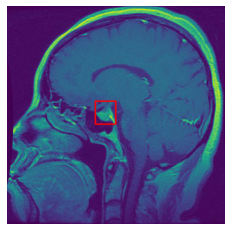

In [ ]:
def show_image_with_boxes(df):
  # pick a random image
  filepath = df.sample()['glioma504.jpg'].values[0]

  # get all rows for this image
  df2 = df[df['glioma504.jpg'] == filepath]
  im = np.array(Image.open('./'+filepath))

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['224'],
      row['108'],
      row['361'],
      row['234'],
    ]
    print(row['glioma'],box)
    draw_box(im, box, color=(255, 0, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()                  
                  
data = pd.read_csv('./train.csv')          
show_image_with_boxes(data)

In [ ]:
data.head()

glioma504.jpg  224  108  361  234           glioma
0       meningioma508.jpg  271  202  335  273       meningioma
1          glioma1197.jpg  255  277  315  345           glioma
2           glioma561.jpg  222  201  303  331           glioma
3  pituitary tumor704.jpg  223  165  309  241  pituitary tumor
4       meningioma633.jpg  268  162  370  245       meningioma

In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet152_oid_v1.0.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

('./snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7fa435a34f60>)

In [61]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {latest_path} --backbone='resnet152' --batch-size 16 --steps 156 --epochs 8 csv train.csv Tumourclasses.csv

2020-08-30 13:28:14.960170: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-08-30 13:28:16.508189: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-30 13:28:16.513033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-30 13:28:16.513471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-08-30 13:28:16.513507: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-30 13:28:16.515151: I t

In [62]:
from glob import glob
model_paths = glob('./snapshots/resnet152_csv_*.h5')
latest_path = "./snapshots/resnet152_csv_08.h5"
print("path:", latest_path)


from keras_retinanet import models

model = models.load_model(latest_path, backbone_name='resnet152')
model = models.convert_model(model)

label_map = {}
for line in open('./Tumourclasses.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

path: ./snapshots/resnet152_csv_08.h5


In [75]:
def show_image_with_predictions(df, threshold=0.6):
  acc = 0
  num = 0
  # choose a random image
  for row in df.itertuples():
    filepath = row[1]
    df2 = df[df['filename'] == filepath]
    im = np.array(Image.open(filepath))

    # if there's a PNG it will have alpha channel
    im = im[:,:,:3]

    # plot true boxes
    box = [
      row[2],
      row[3],
      row[4],
      row[5],
    ]
    label = {j:i for i, j in label_map.items()}[row[6]]

    ### plot predictions ###

    # get predictions
    imp = preprocess_image(im)
    imp, scale = resize_image(im)

    boxes, scores, labels = model.predict_on_batch(
      np.expand_dims(imp, axis=0)
    )

    # standardize box coordinates
    boxes /= scale
    max_score = threshold 
    max_label = -1
    # loop through each prediction for the input image
    for box1, score1, label1 in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can quit as soon
      # as we see a score below threshold
      if score1 > max_score:
        box_p = box1
        score_p = score1
        label_p = label1
        max_score = score1
        max_label = label1
          
    if max_label == label:
      acc += 1
    if num % 20 == 0:
      print(f"Actual : {filepath}")
      b_box = box_p.astype(np.int32)
      color = label_color(label_p)
      draw_box(im, box_p, color=color)
      print(f"Predicted : {label_map[label_p]}, Predicted Confidence : {str(int(score_p * 100)) + '%'}")
      class_name = label_map[label_p]
      caption = f"{class_name} {score_p:.4f}"
      draw_caption(im, b_box, caption)
      draw_box(im, box, color=(255, 0, 0))
      plt.axis('off')
      plt.imshow(im)
      plt.show()
    num += 1
  print(f"Accuracy on around 300 test images: {acc / num}")
plt.rcParams['figure.figsize'] = [20, 10]

Actual : meningioma432.jpg
Predicted : meningioma, Predicted Confidence : 67%


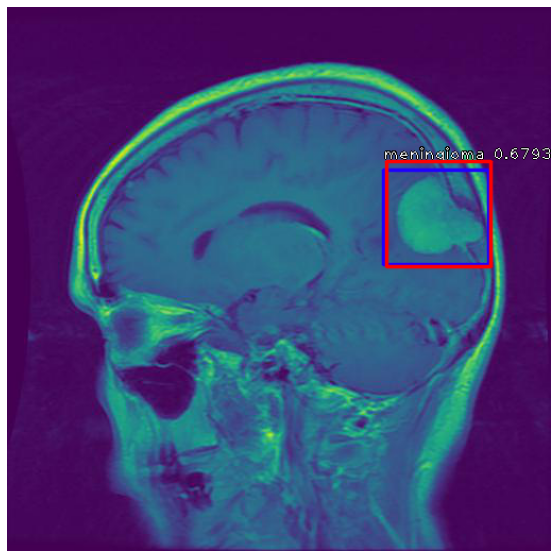

Actual : pituitary tumor352.jpg
Predicted : pituitary tumor, Predicted Confidence : 45%


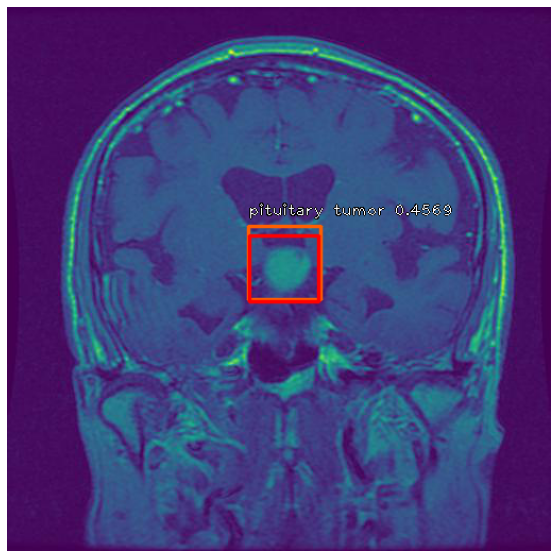

Actual : meningioma20.jpg
Predicted : glioma, Predicted Confidence : 50%


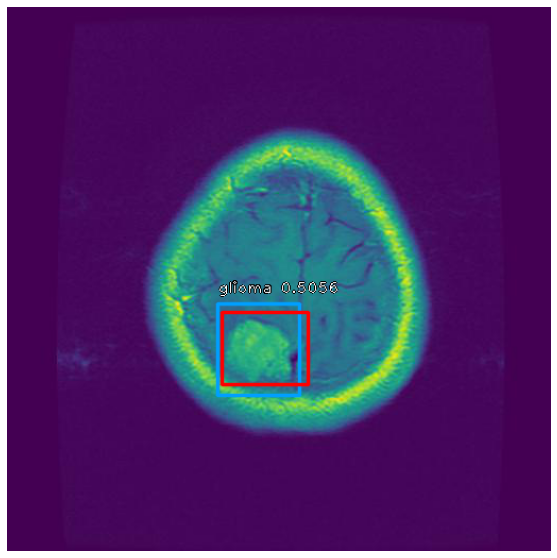

Actual : pituitary tumor53.jpg
Predicted : pituitary tumor, Predicted Confidence : 49%


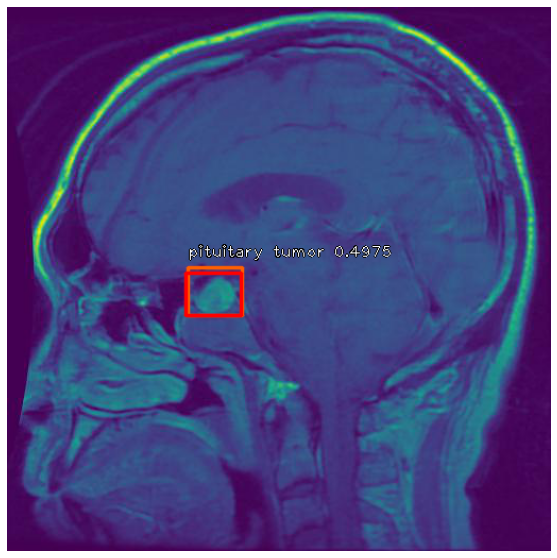

Actual : meningioma175.jpg
Predicted : meningioma, Predicted Confidence : 84%


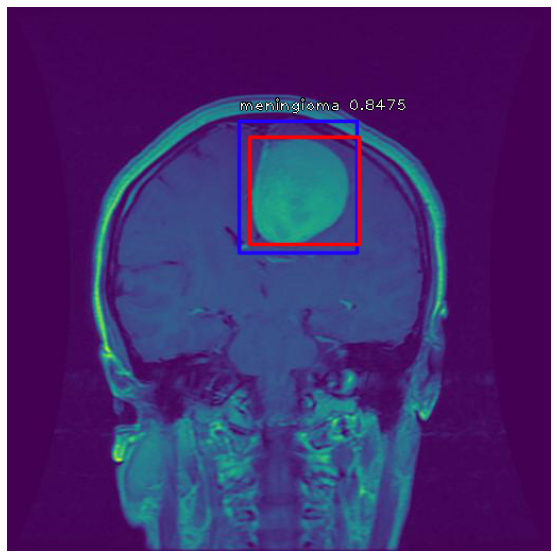

Actual : glioma847.jpg
Predicted : glioma, Predicted Confidence : 59%


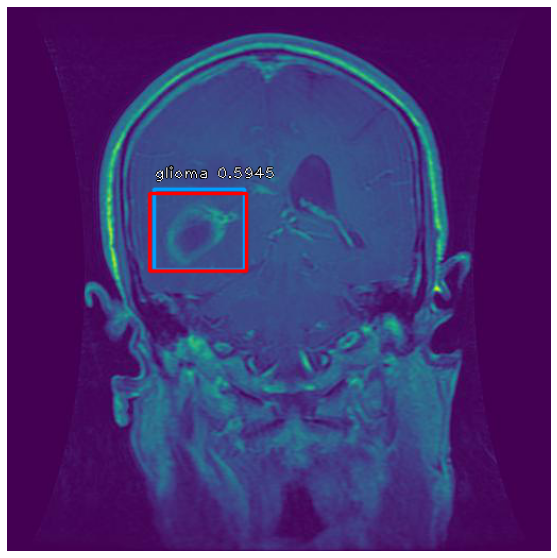

Actual : pituitary tumor211.jpg
Predicted : pituitary tumor, Predicted Confidence : 51%


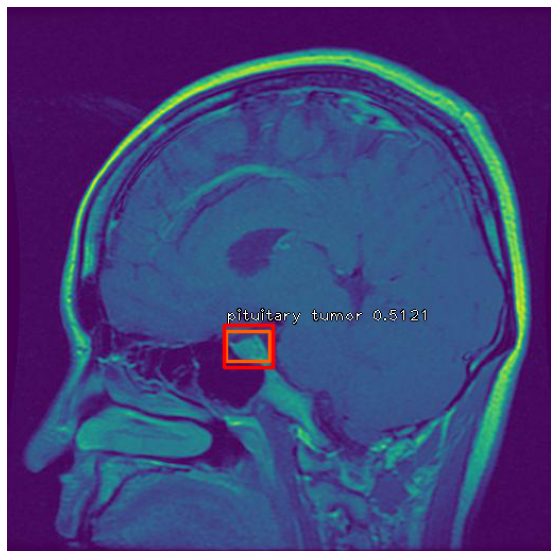

Actual : glioma1261.jpg
Predicted : glioma, Predicted Confidence : 49%


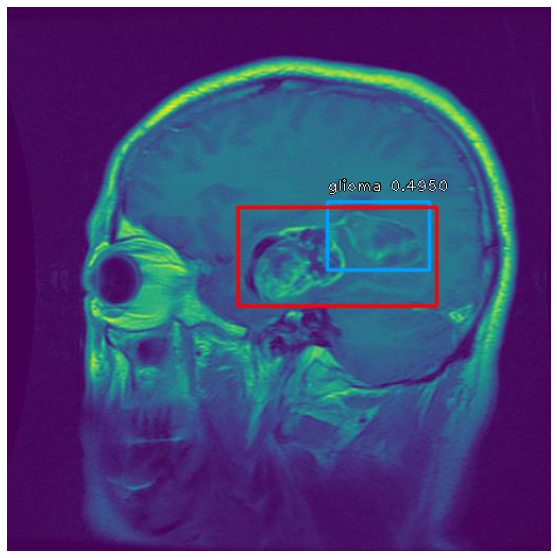

Actual : meningioma514.jpg
Predicted : pituitary tumor, Predicted Confidence : 43%


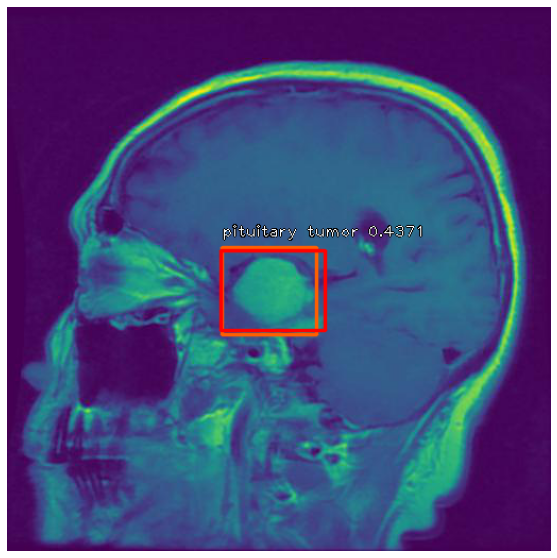

Actual : glioma671.jpg
Predicted : glioma, Predicted Confidence : 55%


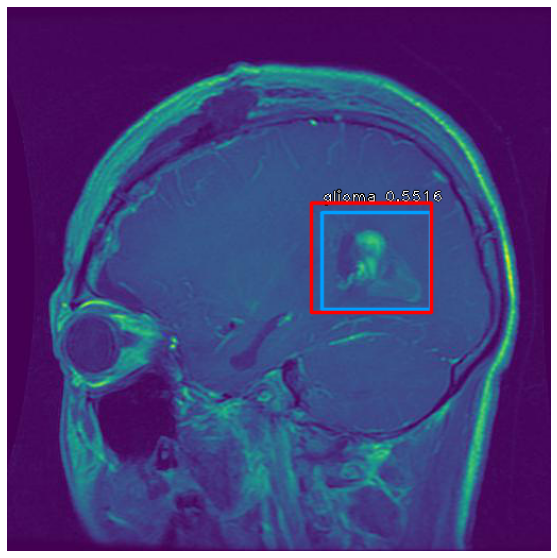

Actual : glioma777.jpg
Predicted : glioma, Predicted Confidence : 40%


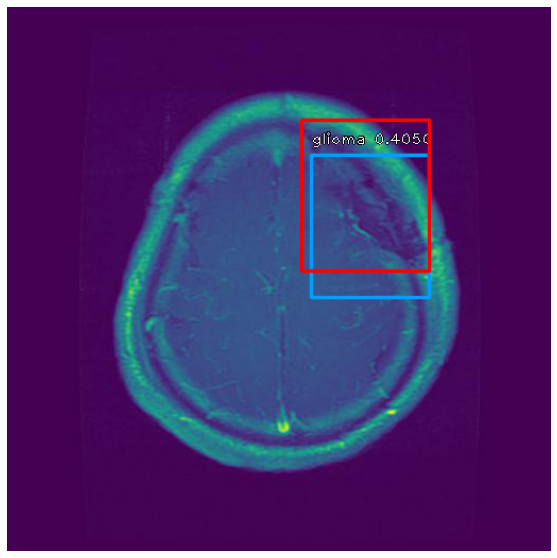

Actual : meningioma36.jpg
Predicted : glioma, Predicted Confidence : 55%


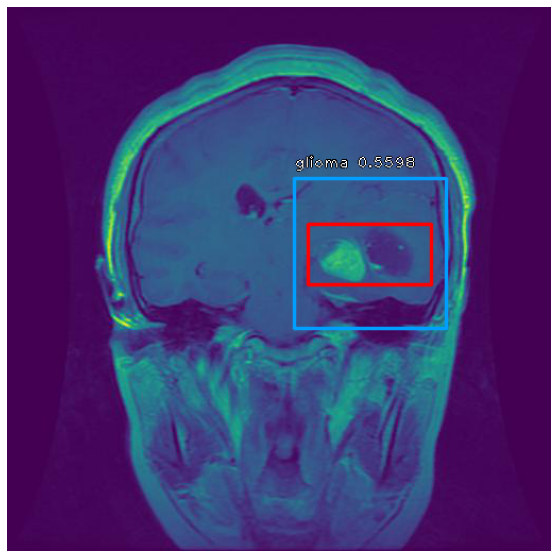

Actual : pituitary tumor807.jpg
Predicted : pituitary tumor, Predicted Confidence : 52%


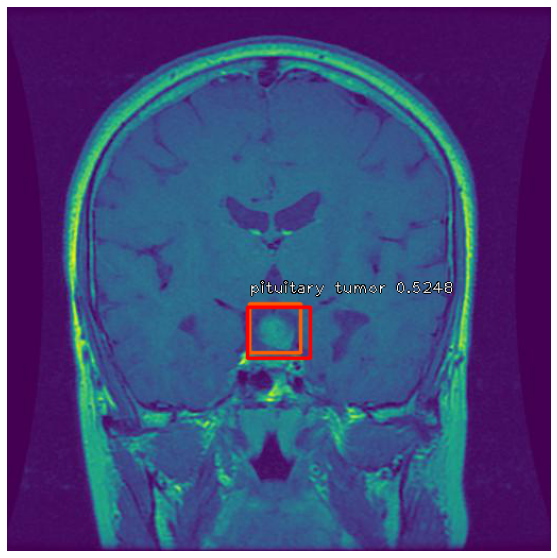

Actual : pituitary tumor430.jpg
Predicted : pituitary tumor, Predicted Confidence : 45%


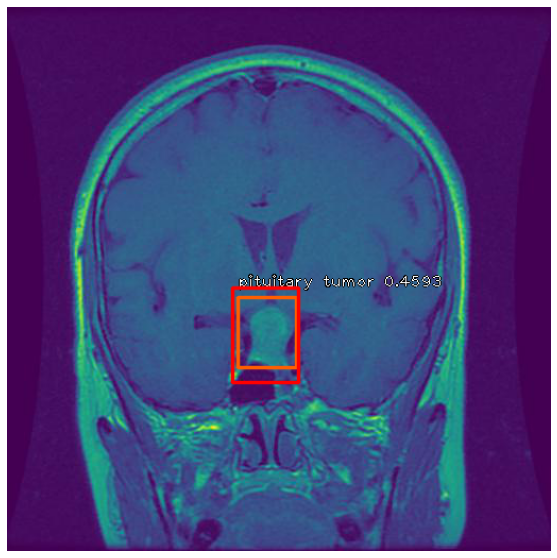

Actual : glioma42.jpg
Predicted : glioma, Predicted Confidence : 71%


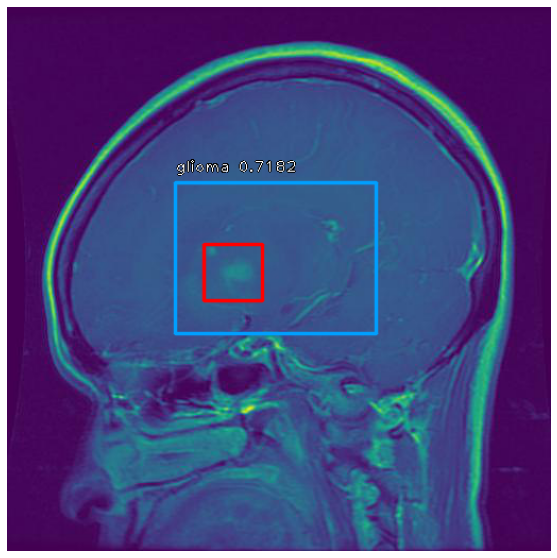

Accuracy on around 300 test images: 0.7591973244147158


In [77]:
 label=show_image_with_predictions(pd.read_csv('./test.csv'), threshold=0.3)